In [1]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import sqlite3
import os
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 데이터 불러오기
~~~
테이블 이름 : DVC0003, DVC0004, DVC0005
~~~

> * ### 1. 데이터 불러오기
> * ### 2. 데이터 확인
>   * ##### a. DVC 별 .info() 확인
>   * ##### b. 정상/비정상 별 데이터 개수 확인
> * #### 3. 데이터 전처리
>   * ##### a. 문자열 칼럼 삭제
>   * ##### b. 학습 데이터 셋 생성

In [2]:
# 1. 데이터 불러오기

conn = sqlite3.connect("./data/Database.db")
cursor = conn.cursor()

query_003 = "SELECT * FROM DVC0003"
query_004 = "SELECT * FROM DVC0004"
query_005 = "SELECT * FROM DVC0005"

df_0003 = pd.read_sql_query(query_003, conn)
df_0004 = pd.read_sql_query(query_004, conn)
df_0005 = pd.read_sql_query(query_005, conn)

In [3]:
# 추후 데이터 가공시 편하게 하기 위해 리스트에 변수들 담음
list_df = [df_0003, df_0004, df_0005]

In [4]:
# 2 .데이터 확인
#   a. .info() 데이터 확인

for df in list_df:
    print(df.info())
    print('==========================================================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833349 entries, 0 to 833348
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   MODELNO               833349 non-null  object 
 1   DEVICECODE            833349 non-null  object 
 2   MP_PRDTIME            833349 non-null  object 
 3   STATUS_MS             833349 non-null  int64  
 4   MP_MINUTE             833349 non-null  object 
 5   System Pressure       833349 non-null  float64
 6   Discharge Pressure    833349 non-null  float64
 7   Stage 3 Inlet Temp    833349 non-null  float64
 8   Stage 1 Vibration     833349 non-null  float64
 9   Stage 2 Vibration     833349 non-null  float64
 10  Stage 3 Vibration     833349 non-null  float64
 11  Oil Pressure          833349 non-null  float64
 12  Oil Temperature       833349 non-null  float64
 13  Drive Motor Current   833349 non-null  float64
 14  Surge Count           833349 non-null  float64
 15  

In [5]:
# 2 .데이터 확인
#   b. 정상/비정상 별 데이터 개수 확인

for df in list_df:
    # 변수이름 추출
    vnames = [name for name in globals() if globals()[name] is df]

    print("df 이름 : {}".format(vnames[0]))
    print("---------------------")
    print("전체 데이터 개수 : {}".format(len(df)))
    print("정상 데이터 갯수: ", len(df[df.STATUS_MS==1]))
    print("비정상 데이터 갯수: ", len(df[df.STATUS_MS==2]))
    print("\n")


df 이름 : df_0003
---------------------
전체 데이터 개수 : 833349
정상 데이터 갯수:  832307
비정상 데이터 갯수:  1042


df 이름 : df_0004
---------------------
전체 데이터 개수 : 833284
정상 데이터 갯수:  833263
비정상 데이터 갯수:  21


df 이름 : df_0005
---------------------
전체 데이터 개수 : 833336
정상 데이터 갯수:  833327
비정상 데이터 갯수:  9




In [15]:
# 3. 데이터 전처리
#   a. 문자열 칼럼 삭제

del_column_list = ["MODELNO", "DEVICECODE", "MP_PRDTIME", "MP_MINUTE"]

# 동적 변수로 전처리 df 생성
# pp_df_0003, pp_df_0004, pp_df_0005
for df in list_df: 
    vnames = [name for name in globals() if globals()[name] is df]
    drop_df = df.drop(del_column_list, axis = "columns")
    drop_df["STATUS_MS"] = drop_df["STATUS_MS"].replace({1 : 0, 2 : 1})
    globals()["pp_{}".format(vnames[0])] = drop_df

In [16]:
pp_df_list = [pp_df_0003, pp_df_0004, pp_df_0005]

In [17]:
# 3. 데이터 전처리
#   b. 학습 데이터 셋 생성

# import copy

# for pp_df in pp_df_list:
#     vnames = [name for name in globals() if globals()[name] is pp_df][0]
#     code_name = vnames.split("_")[-1]
#     x = pp_df.drop(["STATUS_MS"], axis = "columns")
#     y = pp_df["STATUS_MS"]
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
#                                                    random_state=0, stratify=y)
#     globals()["x_train_{}".format(code_name)] = copy.deepcopy(x_train)
#     globals()["x_test_{}".format(code_name)] = copy.deepcopy(x_test)
#     globals()["y_train_{}".format(code_name)] = copy.deepcopy(y_train)
#     globals()["y_test_{}".format(code_name)] = copy.deepcopy(y_test)

In [18]:
# train_data_list = [
#     {x : x_train_0003, y : y_train_0003},
#     {x : x_train_0004, y : y_train_0004},
#     {x : x_train_0005, y : y_train_0005}
# ]
# x_train_list = [x_train_0003, x_train_0004, x_train_0005]
# y_train_list = [y_train_0003, y_train_0004, y_train_0005] 

## 학습 모델 생성
~~~
모델 종류 : XGBoost, CatBoost
~~~

> * ### 1. 데이터 불러오기
> * ### 2. 데이터 확인
>   * ##### a. DVC 별 .info() 확인
>   * ##### b. 정상/비정상 별 데이터 개수 확인
> * #### 3. 데이터 전처리
>   * ##### a. 문자열 칼럼 삭제
>   * ##### b. 학습 데이터 셋 생성

In [21]:
for train_df in pp_df_list:
    vnames = [name for name in globals() if globals()[name] is train_df][0]
    x_train = train_df.drop(["STATUS_MS"], axis = "columns")
    y_train = train_df["STATUS_MS"]

    globals()["xgb_{}".format(vnames.split("_")[-1])] = xgboost.XGBClassifier().fit(x_train, y_train)    

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

In [5]:
# 예시 데이터 import 
# 예시 모델 학습
x = df.drop("")

model = xgboost.XGBRegressor().fit(X, y)

KeyError: "[''] not found in axis"

In [23]:
print(type(xgb_0003))

<class 'xgboost.sklearn.XGBClassifier'>


In [24]:
explainer = shap.Explainer(xgb_0003)
shap_values = explainer(pp_df_0003.drop(["STATUS_MS"], axis = "columns"))

[00:12:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [26]:
print(shap_values.__dict__)

{'op_history': [], 'compute_time': 0.01924300193786621, 'output_dims': (), '_s': Slicer({'o': [], 'values': array([[-2.0645633 ,  0.3229129 ,  3.4250062 , -0.17508136],
       [-0.1587886 , -0.6946155 ,  0.46563995, -0.18548098],
       [ 8.874442  , -0.21311583,  3.1282141 , -0.09238403],
       ...,
       [ 2.711311  , -0.3008216 , -1.2592615 , -0.14786682],
       [ 1.8276973 , -0.3396507 , -1.6782764 , -0.11290564],
       [-4.5272784 , -0.6454306 , -3.9130943 , -0.17274114]],
      dtype=float32), 'base_values': array([22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926

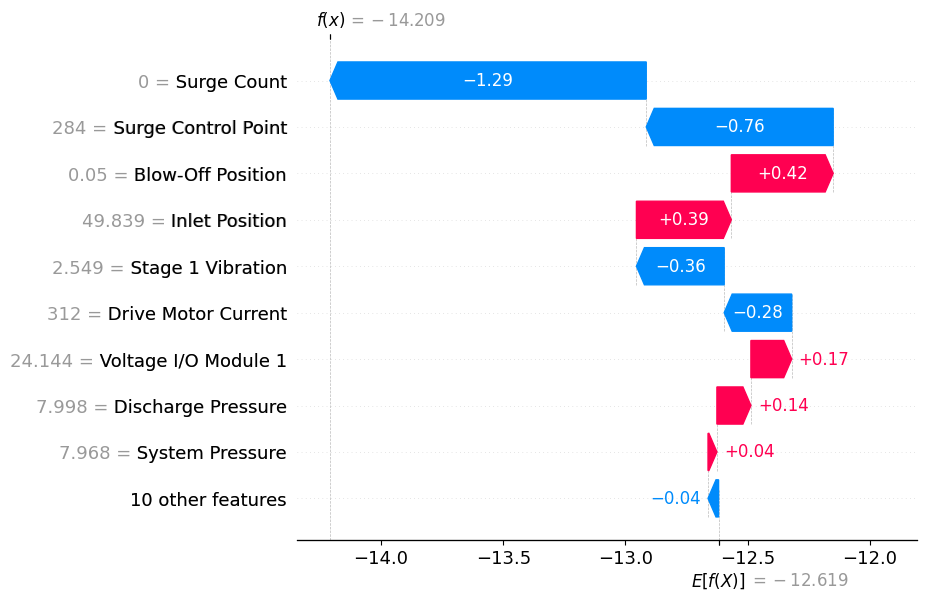

In [25]:
shap.plots.waterfall(shap_values[0])

In [28]:
print(shap_values[0].__dict__)

{'op_history': [{'name': '__getitem__', 'args': ((0,),), 'prev_shape': (506, 4)}], 'compute_time': None, 'output_dims': (), '_s': Slicer({'o': [], 'values': array([-2.0645633 ,  0.3229129 ,  3.4250062 , -0.17508136], dtype=float32), 'base_values': 22.530926, 'data': array([6.32e-03, 1.80e+01, 2.31e+00, 0.00e+00]), 'display_data': None, 'instance_names': None, 'output_names': None, 'output_indexes': None, 'lower_bounds': None, 'upper_bounds': None, 'error_std': None, 'main_effects': None, 'hierarchical_values': None, 'clustering': None})}


In [31]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS'], dtype='object')